In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import scipy.io as scio
import xarray

#import colorcet as cc
#from cmcrameri import cm
import matplotlib.pyplot as plt
import proplot as pplt
from scipy import stats
import spotpy
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

#############################################################
#os.chdir('D:/XanthosDev/Results_11072021/94')
#os.chdir('D:/XanthosDev/Results_11072021/Result_100k')
basinName = pd.read_csv('D:/XanthosDev/example/input/reference/BasinNames235.txt')
basin_id = pd.read_csv('D:/XanthosDev/example/input/reference/basin.csv')
#GRDC_xanthosCoordIndx = pd.read_csv('/project/hli/gabeshu/Guta_Working/Basins_Result/UScells/inputs/GRDC_xanthosCoordIndx.csv')
GRDC_xanthosCoordIndx = pd.read_csv('D:/XanthosDev/example/input/GRDC_stations_selected_final_list.csv')

indx_f = ~((GRDC_xanthosCoordIndx['basins']==58) | (GRDC_xanthosCoordIndx['basins']==84) | (GRDC_xanthosCoordIndx['basins']==169))
GRDC_xanthosCoordIndx = GRDC_xanthosCoordIndx[indx_f].reset_index(drop=True)

basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = []
for ii in range(91):
    indx_basin = basins94[ii] - 1
    basinName_94.append(basinName['BName'][indx_basin])


### Yaling Runoff

In [2]:
YalingRunoff = np.zeros([len(basin_id),240])
for ii in range(235):
    data = scio.loadmat('D:/RunningYalingsData/q_235_basins/235_basins/q_1971_1990_basin_' + str(ii+1) + '.mat')
    QQdata = data['q']
    indx_yl = np.where(basin_id['basin']==(ii+1))[0]
    YalingRunoff[indx_yl, :] = QQdata

# Water Consumption

In [3]:
#Consumption
dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'
Xanthos_reservoirs = xarray.open_dataset('D:/XanthosDev/example/input/calibration/Xanthos_reservoirs_halfDegree_global.nc')
WaterConsumption_mmpermonth = Xanthos_reservoirs.Total_Water_Consumption.values.transpose()
basin_WC_total = np.zeros([91, 480])
for ii in range(91):
    aa = np.where(basin_id['basin'] == basins94[ii])[0]
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad)
    
    # basin_WC_total
    basin_WC = WaterConsumption_mmpermonth[basin_idx,:]
    basin_WC_total[ii,:] = np.nanmean(basin_WC,0)

# GRDC

In [4]:
def precip_seasonality(monthly_prcp):
    from datetime import date, timedelta
    sdate = date(1971,1,1)
    edate = date(1990, 12, 31)
    data_ts = pd.DataFrame(monthly_prcp)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')
        
    mean_monthly = data_ts.groupby(data_ts.index.month).mean()
    mean_annual  = mean_monthly.sum()
    SI = np.sum(np.abs(mean_monthly - (mean_annual/12))) / mean_annual
    return SI    

In [5]:
#GRDC
Xanthos_grid_areas = np.array(pd.read_csv('D:/XanthosDev/example/input/reference/Grid_Areas_ID.csv'))*1e-2 #Km2
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
grdc_mmmPermonth = np.zeros([91, 240])
grdc_m3persec = np.zeros([91, 240])
SI_grdc = np.zeros([91,])
for ii in range(91):
    
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad)
    
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    us_area = np.max([GRDC_xanthosCoordIndx['US_Area_SKM'][ii], GRDC_xanthosCoordIndx['US_Area_SKM'][ii]])   
    if basin_num == 159:
        us_area = GRDC_xanthosCoordIndx['area'][ii]


    ####
    #us_area = GRDC_xanthosCoordIndx['US_Area_SKM'][ii]
    grdc_mmmPermonth[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])*(30.4*24*3600)/us_area/1e3 
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])
    SI_grdc[ii] = precip_seasonality(grdc_m3persec[ii,:])

## plot ggod adjustments
# fig, axs = pplt.subplots(nrows=1, ncols=1, share=0, refheight='3in', refwidth='3in')                                           
# ax = axs[0]
# ax.scatter(GRDC_xanthosCoordIndx['r_height_yr']/12, np.mean(grdc_mmmPermonth, 1))
# ax.plot([0, 170], [0, 170], 'r')
# ax.format(xscale='log', yscale='log', 
#            xlabel='From GRDC (mm/month)', 
#            ylabel='Computed Here (mm/month)')

# Precipitation and ET

In [6]:
# get grid indices for the current basin
dir_usgrid = 'D:/XanthosDev/Figures/Basins_Result/UScells/contributing_grids_all'
#precipitation
dataP = np.load('D:/XanthosDev/example/input/climate/gswp3_precip_for_calib_1971_2010.npy')
dataPwatch = np.load('D:/XanthosDev/example/input/climate/pr_gpcc_watch_monthly_mmpermth_1971_2001.npy')
#ET
dataET = np.load('D:/XanthosDev/example/input/calibration/' +
                 'ET.RS_METEO.EBC-ALL.MLM-ALL.METEO-GSWP3.720_360.monthly.1971_2010.npy')
dataET[dataET<0] = 0
ETscaler = np.load('D:/XanthosDev/example/input/calibration/ETscaler.npy')

#PET
dataPET = np.load('D:/XanthosDev/example/input/pet/penman_monteith/gswp3_pet_for_calib_1971_2010.npy')
dataPETwatch = np.load('D:/XanthosDev/example/input/pet/penman_monteith/penman_monteith_watch_monthly_pet_1971_2001.npy')


dataET[dataET > dataPET] = dataPET[dataET > dataPET] 

Pmonthly = np.zeros([91,480])
Pmonthlywatch= np.zeros([91,372])
ETmonthly_obs = np.zeros([91,372])
PETmonthly_PM = np.zeros([91,480])
PETmonthly_PMwatch= np.zeros([91,372])
YalingRunoffBasins= np.zeros([91,240])
for ii in range(91):
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    
    #P
    Pmonthly[ii,:] = np.mean(dataP[basin_idx,:],0)
    Pmonthlywatch[ii,:] = np.mean(dataPwatch[basin_idx,:],0)

    # Basin ET, PET
    basinET = np.mean(dataET[basin_idx,:], 0)*ETscaler[ii,1] 
    basinPET = np.mean(dataPET[basin_idx,:],0)
    basinET[basinET > basinPET] = basinPET[basinET > basinPET]
    #ET
    ETmonthly_obs[ii,:] = basinET[0:372]
    
    #PET
    PETmonthly_PM[ii,:] = basinPET
    PETmonthly_PMwatch[ii,:] = np.mean(dataPETwatch[basin_idx,:],0)   

    #Yaling Runoff
    YalingRunoffBasins[ii,:] = np.mean(YalingRunoff[basin_idx,:], 0)     


# WM

In [7]:
#Xanthos_reservoirs = xarray.open_dataset('D:/XanthosDev/example/input/calibration/Xanthos_reservoirs_halfDegree_global.nc')
Capacity = Xanthos_reservoirs.Capacity.values
Capacity_usgrid = np.zeros([91,2])

for ii in range(91):
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    Capacity_usgrid[ii,0] = basin_num
    Capacity_usgrid[ii, 1] = np.sum(Capacity[basin_idx])  

    

Capacity_usgrid_df = pd.DataFrame(Capacity_usgrid)    
Capacity_usgrid_df.columns = ['Basin','Capacity_MCM']  

# Long-term

In [8]:
long_term_data = pd.DataFrame()
long_term_data['Basin'] = basins94
long_term_data['BasinName'] = basinName_94
long_term_data['Q'] = np.mean(grdc_mmmPermonth,1)
long_term_data['P'] = np.mean(Pmonthly,1)
long_term_data['Pwatch'] = np.mean(Pmonthlywatch,1)
long_term_data['P-Q'] = np.mean(Pmonthly,1) - np.mean(grdc_mmmPermonth,1) 

#long_term_data['WC'] = np.mean(basin_WC_total,1)
long_term_data['ETobs'] = np.mean(ETmonthly_obs,1)
long_term_data['PETpm'] = np.mean(PETmonthly_PM,1)
long_term_data['PETwatch'] = np.mean(PETmonthly_PMwatch,1)
long_term_data['WC'] = np.mean(basin_WC_total,1)

long_term_data['Scaling Coeff.'] = np.divide(long_term_data['P-Q'], long_term_data['ETobs'])
#long_term_data['Scaling Coeff2.'] = np.divide(long_term_data['P-Q2'], long_term_data['ETobs'])
long_term_data['DA'] = GRDC_xanthosCoordIndx['US_Area_SKM']
long_term_data['Capacity_MCM'] = Capacity_usgrid_df['Capacity_MCM']
#long_term_data['lta_discharge_MCM'] = GRDC_xanthosCoordIndx['lta_discharge']*365*24*3600 / 1e6
long_term_data['lta_discharge_MCM'] = np.mean(grdc_m3persec,1)*365*24*3600 / 1e6

long_term_data['RII'] = np.divide(long_term_data['Capacity_MCM'], long_term_data['lta_discharge_MCM'])
#long_term_data[['RII']].boxplot()

# Performance Results filtering

### functions

In [9]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')
    ##
    mean_monthly_data = np.squeeze(np.array(data_ts.groupby(data_ts.index.month).mean()))
    mean_annual_data = np.squeeze(np.array(data_ts.resample('A').sum()))

    return mean_monthly_data, mean_annual_data

In [10]:
def runoff_error(performance_data, QQmm, Qwc, qq):
    QRerror = performance_data['R'] - np.mean(QQmm) - np.mean(Qwc)
    performance_data['QRerror'] = np.abs(QRerror) / np.mean(QQmm)
    q10_wbre = performance_data['QRerror'].quantile(q=qq) 
    index1_q10_wbre = (performance_data['QRerror'] <= q10_wbre) 
    QR_filtered_performance_data = performance_data[index1_q10_wbre].reset_index(drop=True)

    return QR_filtered_performance_data

In [11]:
def et_error(performance_data_, qq):    
    q10_ETer = performance_data_['RelativeError'].quantile(q=qq) 
    index1_q10_etre = (performance_data_['RelativeError'] <= q10_ETer)    
    WBRE_filtered_performance_data = performance_data_[index1_q10_etre].reset_index(drop=True)

    return WBRE_filtered_performance_data

In [12]:
def peak_time_differnce(WB_filtered_performance_data, lowRII_Basins, basin_num):   
    if len(np.where(lowRII_Basins==basin_num)[0]) > 0:   
        indx_months_pt1 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -1) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
        PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt1].reset_index(drop=True)
        
        if PT_filtered_performance_data.shape[0] < 100:
            indx_months_pt2 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -2) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
            PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt2].reset_index(drop=True)

        #if PT_filtered_performance_data.shape[0] < 500:
        #    indx_months_pt2 = ((WB_filtered_performance_data['MNTH_PDiff'] >= -3) & (WB_filtered_performance_data['MNTH_PDiff'] <= 3))
        #    PT_filtered_performance_data = WB_filtered_performance_data[indx_months_pt2].reset_index(drop=True)
    else:
        PT_filtered_performance_data = WB_filtered_performance_data
    
    return PT_filtered_performance_data


In [13]:
def runoff_model_output(dir_in, basin_num):
    os.chdir(dir_in)
    basin_calibration =  pd.read_csv('basin_calibration_' + str(basin_num) + 'c.csv')
    basin_calibration = basin_calibration.drop(['para',	'parb',	'parc',	'pard',	'parm'], 1)
    ## basin_abcd
    basin_abcd = basin_calibration[['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5']]
    basin_abcd.columns = ['par_a',	'par_b',	'par_c',	'par_d',	'par_m']
    basin_calibration = basin_calibration.drop(['simulation1_1', 'simulation1_2', 'simulation1_3', 'simulation1_4', 'simulation1_5'], 1)

    ######### Runoff
    ## basin annual runoff
    basin_annaul_RO  = basin_calibration[['simulation2_1', 'simulation2_2', 'simulation2_3',
                                            'simulation2_4', 'simulation2_5', 'simulation2_6', 'simulation2_7',
                                            'simulation2_8', 'simulation2_9', 'simulation2_10', 'simulation2_11',
                                            'simulation2_12', 'simulation2_13', 'simulation2_14', 'simulation2_15',
                                            'simulation2_16', 'simulation2_17', 'simulation2_18', 'simulation2_19',
                                            'simulation2_20', 'simulation2_21', 'simulation2_22', 'simulation2_23',
                                            'simulation2_24', 'simulation2_25', 'simulation2_26', 'simulation2_27',
                                            'simulation2_28', 'simulation2_29', 'simulation2_30', 'simulation2_31']]
    basin_annaul_RO.columns = np.arange(1971,2002, 1)   
    ## basin mean monthly runoff
    basin_MM_RO   = basin_calibration[['simulation3_1', 'simulation3_2', 'simulation3_3', 'simulation3_4',
                                        'simulation3_5', 'simulation3_6', 'simulation3_7', 'simulation3_8',
                                        'simulation3_9', 'simulation3_10', 'simulation3_11', 'simulation3_12']]
    basin_MM_RO.columns  = [['Ja', 'Fb', 'Mr', 'Ap', 'My', 'Ju', 'Jl', 'Ag', 'Sb', 'Oc', 'Nv', 'Dc']]


    ######## ET
    ## basin annual ET
    basin_annaul_ET  = basin_calibration[['simulation4_1', 'simulation4_2', 'simulation4_3', 'simulation4_4',
                                            'simulation4_5', 'simulation4_6', 'simulation4_7', 'simulation4_8',
                                            'simulation4_9', 'simulation4_10', 'simulation4_11', 'simulation4_12',
                                            'simulation4_13', 'simulation4_14', 'simulation4_15', 'simulation4_16',
                                            'simulation4_17', 'simulation4_18', 'simulation4_19', 'simulation4_20',
                                            'simulation4_21', 'simulation4_22', 'simulation4_23', 'simulation4_24',
                                            'simulation4_25', 'simulation4_26', 'simulation4_27', 'simulation4_28',
                                            'simulation4_29', 'simulation4_30', 'simulation4_31']]
    basin_annaul_ET.columns = np.arange(1971,2002, 1)   

    ## basin mean monthly ET
    basin_MM_ET   = basin_calibration[['simulation5_1','simulation5_2', 'simulation5_3', 'simulation5_4', 'simulation5_5',
                    'simulation5_6', 'simulation5_7', 'simulation5_8', 'simulation5_9',
                    'simulation5_10', 'simulation5_11', 'simulation5_12']]
    basin_MM_ET.columns  = [['Ja', 'Fb', 'Mr', 'Ap', 'My', 'Ju', 'Jl', 'Ag', 'Sb', 'Oc', 'Nv', 'Dc']]

    return basin_abcd, basin_annaul_RO, basin_MM_RO, basin_annaul_ET, basin_MM_ET


In [14]:
def Rsquared_matrix(basin_annual_runoff_all, annual_ro_mat):
    aa1 = pd.DataFrame(annual_ro_mat) - np.mean(annual_ro_mat)
    mm_meanro = np.reshape(np.tile(np.mean(basin_annual_runoff_all, 1),20), 
                                  [20, basin_annual_runoff_all.shape[0]]).transpose()
    aa2 = pd.DataFrame(basin_annual_runoff_all) - mm_meanro
    aa = np.multiply(aa1,aa2).sum(axis=1)
    bb1 = (aa1**2).sum(axis=1)
    bb2 = (aa2**2).sum(axis=1)
    bb = np.sqrt(np.multiply(bb1, bb2))

    rcoeff = np.array(np.divide(aa, bb))

    return rcoeff

In [15]:
def kge_matrix(basin_annual_runoff_all, annual_ro_mat, annual_ro):    
    stdbais_annual_ro  = (1 - (np.std(basin_annual_runoff_all,1) /np.std(annual_ro)))**2
    meanbais_annual_ro = (1 - (np.mean(basin_annual_runoff_all,1) /np.mean(annual_ro)))**2
    rsquared_bias      = ( 1 - Rsquared_matrix(basin_annual_runoff_all, annual_ro_mat))**2
    ed_distance = stdbais_annual_ro + meanbais_annual_ro + rsquared_bias
    kge_value_ = 1 - np.sqrt(ed_distance)
    return kge_value_

## Filter 1 : Annual Runoff
## Filter 2 : Annual ET

In [16]:
def parameters_set_selection(performance_data_in, grdc_depth, basins94, basin_num): 
    # runoff data
    performance_data = performance_data_in.copy()
    bb = np.where(basins94==basin_num)[0]
    performance_data.columns = [1,2,3,4,5,6,7,8,9,10,11,12]
    performance_data['MNTH_RP'] = np.array(performance_data.idxmax(axis=1))


    #Q: Peak timing   
    QQmm, QQaa = timeseries_coverter(grdc_depth, start_yr=1971, ending_yr=1990)
    QQmm_df = pd.DataFrame(QQmm)
    QQmm_df.index = [1,2,3,4,5,6,7,8,9,10,11,12]
    performance_data['MNTH_QP'] = QQmm_df.idxmax()[0]*np.ones([performance_data.shape[0],])

    # difference
    performance_data['PT_Diff'] = performance_data['MNTH_QP'] - performance_data['MNTH_RP']

    return performance_data

In [17]:
# start_yr = 1971
# ending_yr = 1990
# rmse_annual_et = np.ones([1000000, 91])*np.nan
# kge_annual_et = rmse_annual_et.copy()
# rmse_annual_ro = rmse_annual_et.copy()
# kge_annual_ro = rmse_annual_et.copy()
# dir_in = 'D:\\Xanthos-Repo\\Data for Figures-Xanthos WM\\WATCH-1M-Run-abcdm'
# # SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
# # #sensetivity_aa = np.zeros([91,5])
# for ii in tqdm(range(1)):#range(81, 91)):
#     ii=30
#     basin_num = basins94[ii]
#     bb = np.where(basins94==basin_num)[0]
#     ## Get data : simulated   
#     basin_abcd, basin_annaul_RO, basin_MM_RO, basin_annaul_ET, basin_MM_ET = runoff_model_output(dir_in, basin_num)

#     QQmm, QQaa = timeseries_coverter(np.squeeze(grdc_mmmPermonth[bb,:]), start_yr=1971, ending_yr=1990)
#     basin_annaul_RO['Qannual_error'] = np.abs(basin_annaul_RO.mean(axis=1) - np.mean(QQaa))/np.mean(QQaa)

#     basin_annual_runoff = np.array(basin_annaul_RO)
#     basin_annual_et = np.array(basin_annaul_ET)    
#     ## Get data : observed    
#     mean_monthly_ro, annual_ro = timeseries_coverter(np.squeeze(grdc_mmmPermonth[bb,:]), start_yr, ending_yr)
#     mean_monthly_et, annual_et = timeseries_coverter(np.squeeze(ETmonthly_obs[bb,:]), start_yr=1971, ending_yr=2001)
#     # compute metrics
#     annual_ro_dup = np.multiply(np.ones_like(basin_annual_runoff[:,0:20]),annual_ro)
#     annual_et_dup = np.multiply(np.ones_like(basin_annual_et),annual_et)


#     ############ Runoff rmse
#     rmse_annual_ro = np.sqrt(np.sum((basin_annual_runoff[:,0:20] - annual_ro_dup)**2, 1)  / len(annual_ro))
#     ############ ET rmse
#     rmse_annual_et = np.sqrt(np.sum((basin_annual_et- annual_et_dup)**2, 1)  / len(annual_et))

#     #param_a  = basin_parameters['para']
#     sensetivity_aa[ii,0] = np.corrcoef(basin_abcd['par_a'],rmse_annual_ro)[0,1]
#     sensetivity_aa[ii,1] = np.corrcoef(basin_abcd['par_b'],rmse_annual_ro)[0,1]
#     sensetivity_aa[ii,2] = np.corrcoef(basin_abcd['par_c'],rmse_annual_ro)[0,1]
#     sensetivity_aa[ii,3] = np.corrcoef(basin_abcd['par_d'],rmse_annual_ro)[0,1]
#     sensetivity_aa[ii,4] = np.corrcoef(basin_abcd['par_m'],rmse_annual_ro)[0,1]


In [18]:
#sensetivity_aa_df = pd.DataFrame(sensetivity_aa)
#sensetivity_aa_df.columns = ['par_a','par_b','par_c','par_d','par_m']

sensetivity_dir = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\Desktop\\Xanthos-Manuscript\\Manuscript-09072022\\Figures-Updated\\'
#sensetivity_aa_df.to_csv(sensetivity_dir+"sensetivity_aa_df.csv", index=False)
sensetivity_aa = np.array(pd.read_csv(sensetivity_dir+"sensetivity_aa_df.csv"))

In [19]:
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\calibration results\\basin_calibration_'
basiNum = []
sensetivity_mmflow = np.zeros([91,6])
for ii in range(91):
    basin_num = basins94[ii]    
    ## observed
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])

    ## simulated
    data_basin = pd.read_csv(file_dir_watch_vald + str(basin_num) + '.csv')
    # best
    kge_flow = np.array(data_basin['like1'])
    basiNum.append('Basin '+ str(basin_num))
    #param_a  = basin_parameters['para']
    sensetivity_mmflow[ii,0] = np.corrcoef(data_basin['para'],kge_flow)[0,1]
    sensetivity_mmflow[ii,1] = np.corrcoef(data_basin['parb'],kge_flow)[0,1]
    sensetivity_mmflow[ii,2] = np.corrcoef(data_basin['parc'],kge_flow)[0,1]
    sensetivity_mmflow[ii,3] = np.corrcoef(data_basin['pard'],kge_flow)[0,1]
    sensetivity_mmflow[ii,4] = np.corrcoef(data_basin['parm'],kge_flow)[0,1]
    sensetivity_mmflow[ii,5] = np.corrcoef(data_basin['parwmbeta'],kge_flow)[0,1] 

In [20]:
os.chdir('C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\\Xanthos-Manuscript\\Manuscript\\Revision-06\\Figures-List-08-22-2022\\archive')

#### Demand Basin Average

In [21]:
basinName = pd.read_csv('D:/XanthosDev/example/input/reference/BasinNames235.txt')
basin_id = pd.read_csv('D:/XanthosDev/example/input/reference/basin.csv')
GRDC_xanthosCoordIndx = pd.read_csv('D:/XanthosDev/example/input/GRDC_stations_selected_final_list.csv')
indx_f = ~((GRDC_xanthosCoordIndx['basins']==58) | (GRDC_xanthosCoordIndx['basins']==84) | (GRDC_xanthosCoordIndx['basins']==169))
GRDC_xanthosCoordIndx = GRDC_xanthosCoordIndx[indx_f].reset_index(drop=True)
basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)

## Demand
os.chdir('C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\\Xanthos-Manuscript\\figures-v2')
basin_xnths = np.array(pd.read_csv("basin.csv"))
data_demand = scio.loadmat("Total_Water_Demand_mmpermonth_1971_2010.mat")
Basin_demand1 = data_demand["Total_Water_Demand"]
Basin_demand = np.nanmean(Basin_demand1, axis=1)
demand_basinD  = np.ones([len(basins94),1]) * np.nan
for ii in range(len(basins94)):
    basin_dd = basins94[ii]
    indx_basin = np.squeeze(basin_xnths == basin_dd)
    demand_basinD[ii] = np.nanmean(Basin_demand[indx_basin])

GRDC_xanthosCoordIndx['Demand_mmperMonth'] = demand_basinD

##### Streamflow

In [22]:
data_flow = pd.DataFrame(sensetivity_mmflow)
data_flow.columns = [r'$\bf{{{a}}}$', r'$\bf{{{b}}}$', r'$\bf{{{c}}}$', r'$\bf{{{d}}}$', r'$\bf{{{m}}}$',r'$\bf{{{ \beta }}}$']
data_flow['basins'] = basins94
data_flow['basiName'] = basinName_94
data_flow['basiN'] = basiNum

# Merge runoff data with demand
data_flow_demand_merged = data_flow.merge(GRDC_xanthosCoordIndx[['basins','Demand_mmperMonth']], on='basins')
data_flow_demand_merged = data_flow_demand_merged.sort_values(by='Demand_mmperMonth', ascending=False).reset_index(drop=True)

## Top 46 based on demand
data_flow_demand_merged_1 = data_flow_demand_merged.loc[np.arange(0,46,1)]
data_flow_demand_merged_1.index = np.arange(0,91,2) # index with even

## Bottom 45 based on demand
data_flow_demand_merged_2 = data_flow_demand_merged.loc[np.arange(46,91,1)]
data_flow_demand_merged_2.index = np.arange(1,91,2) #index with odd

## combine odds and eeven index again
data_flow_demand_merged_3 = pd.concat([data_flow_demand_merged_1, data_flow_demand_merged_2], axis=0).sort_index()
data_flow_demand_merged_3.head(10)

,$\bf{{{a}}}$,$\bf{{{b}}}$,$\bf{{{c}}}$,$\bf{{{d}}}$,$\bf{{{m}}}$,$\bf{{{ \beta }}}$,basins,basiName,basiN,Demand_mmperMonth
0,-0.018425,-0.001907,0.052353,0.046472,-0.050426,-0.542764,57,Po,Basin 57,14.360243
1,-0.187760,0.198349,-0.060723,0.026529,-0.045868,-0.008305,213,Negro,Basin 213,1.053780
2,-0.309965,0.587802,0.247001,-0.304519,0.068442,-0.385583,32,Rhine,Basin 32,13.331002
3,-0.054414,0.425992,0.139625,0.073954,-0.431749,-0.495024,43,Amur,Basin 43,1.030932
4,-0.002320,0.364860,0.338116,0.114133,-0.005799,-0.521551,77,Ziya He Interior,Basin 77,12.377112
5,0.058787,0.342430,-0.093037,-0.001334,0.208216,0.029962,38,Ural,Basin 38,0.904101
6,0.174831,0.471325,0.340654,0.138114,-0.238315,-0.297465,110,Ganges - Bramaputra,Basin 110,10.400553
7,0.067938,-0.104385,-0.104200,0.049856,-0.026230,-0.342811,206,La Plata,Basin 206,0.883055
8,-0.047291,0.614371,0.204610,-0.033230,-0.099418,-0.291342,233,Mid Atlantic Basin,Basin 233,8.917537
9,0.003385,0.630551,0.157868,-0.152690,-0.001181,-0.415458,199,Limpopo,Basin 199,0.803622


#### Runoff

In [23]:
data_runoff = pd.DataFrame(sensetivity_aa)
data_runoff.columns = [r'$\bf{{{a}}}$', r'$\bf{{{b}}}$', r'$\bf{{{c}}}$', r'$\bf{{{d}}}$', r'$\bf{{{m}}}$']
data_runoff['basins'] = basins94
data_runoff['basiName'] = basinName_94
data_runoff['basiN'] = basiNum
#datad.to_csv('datad_runoff.csv', index=False)

# Merge runoff data with demand
data_runoff_demand_merged = data_runoff.merge(GRDC_xanthosCoordIndx[['basins','Demand_mmperMonth']], on='basins')
data_runoff_demand_merged = data_runoff_demand_merged.sort_values(by='Demand_mmperMonth', ascending=False).reset_index(drop=True)

## Top 46 based on demand
data_runoff_demand_merged_1 = data_runoff_demand_merged.loc[np.arange(0,46,1)]
data_runoff_demand_merged_1.index = np.arange(0,91,2) # index with even

## Bottom 45 based on demand
data_runoff_demand_merged_2 = data_runoff_demand_merged.loc[np.arange(46,91,1)]
data_runoff_demand_merged_2.index = np.arange(1,91,2) #index with odd

## combine odds and eeven index again
data_runoff_demand_merged_3 = pd.concat([data_runoff_demand_merged_1, data_runoff_demand_merged_2], axis=0).sort_index()
data_runoff_demand_merged_3.head(10)

,$\bf{{{a}}}$,$\bf{{{b}}}$,$\bf{{{c}}}$,$\bf{{{d}}}$,$\bf{{{m}}}$,basins,basiName,basiN,Demand_mmperMonth
0,-0.603715,0.554758,0.024241,-0.015480,1.036242e-01,57,Po,Basin 57,14.360243
1,-0.620079,0.481769,-0.000315,0.014770,2.219929e-01,213,Negro,Basin 213,1.053780
2,-0.567361,0.514015,0.009021,0.004961,1.485979e-01,32,Rhine,Basin 32,13.331002
3,-0.597504,0.520260,-0.008645,0.019731,1.119314e-01,43,Amur,Basin 43,1.030932
4,-0.636320,0.520652,-0.008193,0.014795,2.543207e-02,77,Ziya He Interior,Basin 77,12.377112
5,-0.596029,0.506313,-0.011541,0.020666,1.537485e-01,38,Ural,Basin 38,0.904101
6,-0.569698,0.440848,0.019830,0.021911,4.485652e-01,110,Ganges - Bramaputra,Basin 110,10.400553
7,-0.682201,0.475105,-0.009069,0.021096,-5.924033e-07,206,La Plata,Basin 206,0.883055
8,-0.594473,0.509152,0.001718,0.009082,1.204291e-01,233,Mid Atlantic Basin,Basin 233,8.917537
9,-0.683001,0.490384,-0.000674,0.010667,-6.963177e-04,199,Limpopo,Basin 199,0.803622


#### Plotting

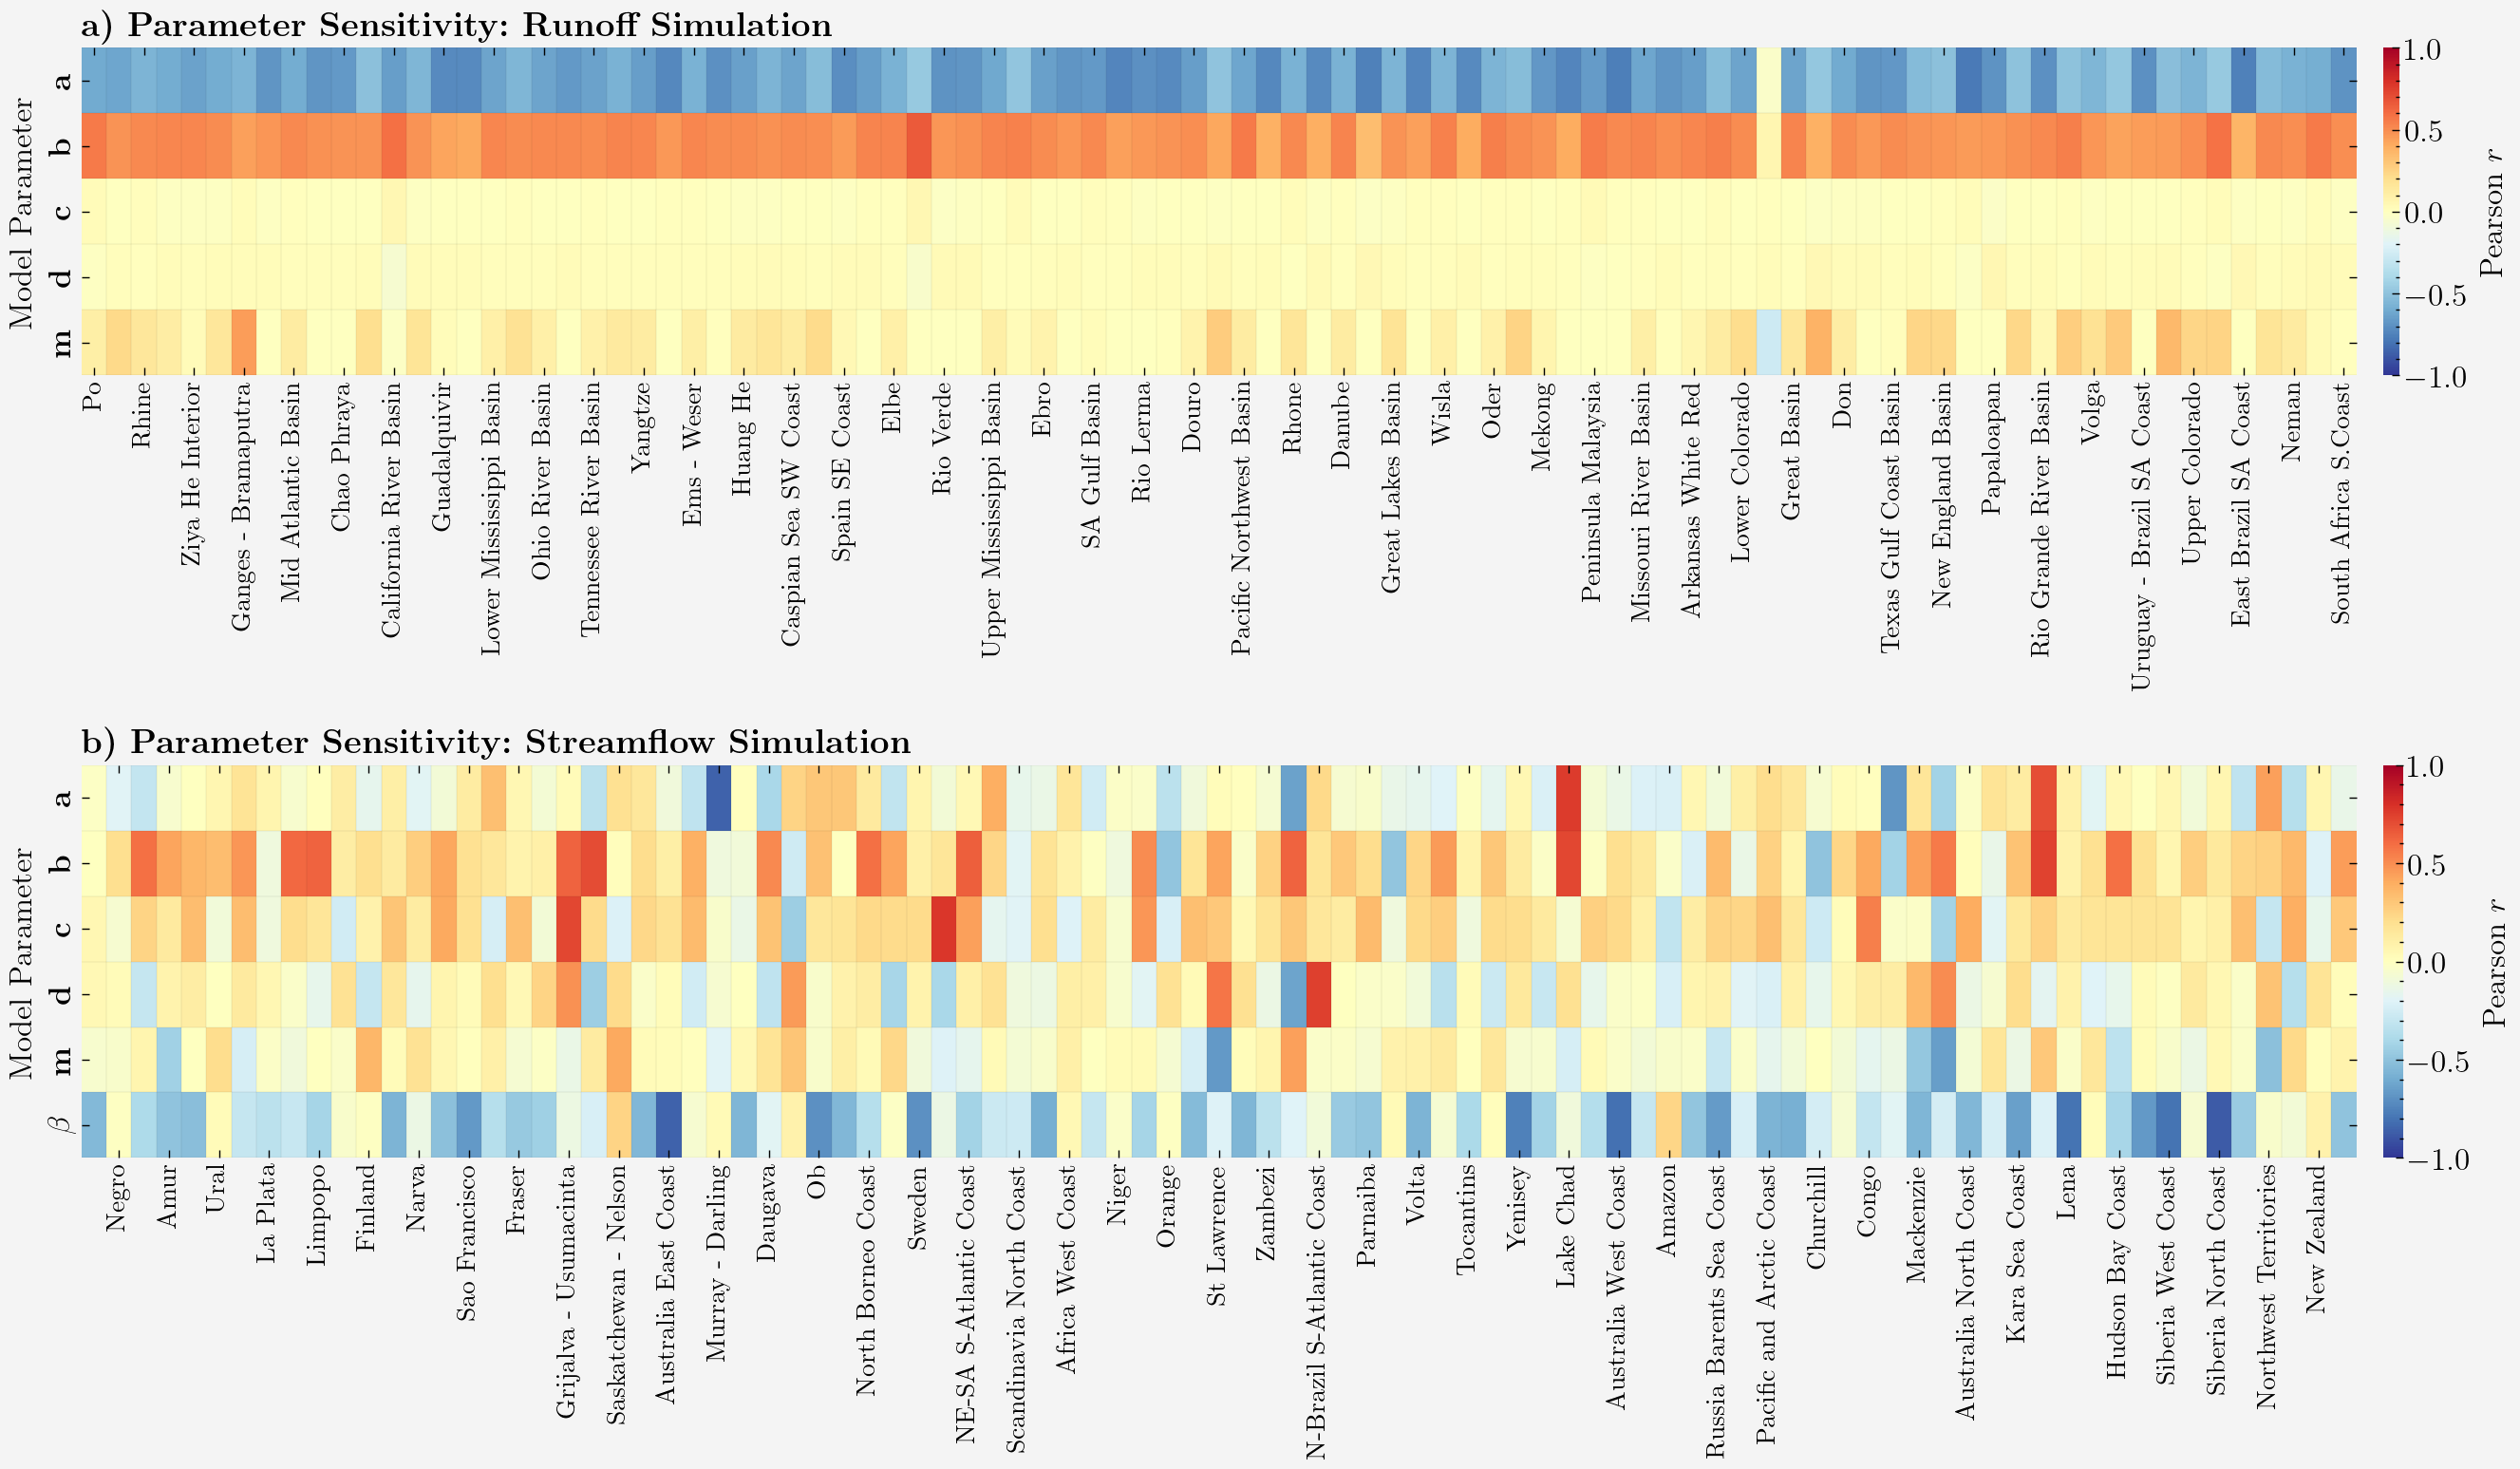

In [24]:
# xarray
import xarray 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12, 'font.weight':'bold'}) 

plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'

sensetivity_aa_df = pd.DataFrame(sensetivity_aa)
sensetivity_aa_df.columns =  [r'$\bf{{{a}}}$', r'$\bf{{{b}}}$', r'$\bf{{{c}}}$', r'$\bf{{{d}}}$', r'$\bf{{{m}}}$']


plt.style.use('science')
## figure saving
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
## Plotting
with plt.style.context(['science', 'high-contrast']):  
    
    #fig, axs = pplt.subplots(ncols=1, nrows=1, wratios=(1, 1), refheight=8.0, refwidth=4.0, span=True)
    fig,(ax1,ax2) = plt.subplots(2,1,  figsize=(15, 8),
                                 gridspec_kw={'height_ratios':[1,1.2]})

    ## Runoff parameters only
    #data_runoff['basiName'][54] = 'NE SA South Atlantic Coast'
    datadx_runoff = data_runoff_demand_merged_3.drop(['basins','basiName','basiN','Demand_mmperMonth'],1)
    datadx_runoff.index = data_runoff_demand_merged_3.basiName
    g1 = sns.heatmap(datadx_runoff.transpose(), cmap="RdYlBu_r", 
                    yticklabels=True, vmin=-1, vmax=1, center=0,
                    cbar_kws={'label': 'Pearson $r$',"shrink":1.0,'pad':0.01},
                    cbar=True, ax=ax1)
    g1.hlines([0, 1, 2, 3, 4, 5, 6], *g1.get_xlim(), color='k', linewidth=0.025)
    g1.vlines(list(np.arange(1,91,1)), *g1.get_ylim(), color='k', linewidth=0.025)
    g1.minorticks_off()
    g1.set_xticklabels([])
    g1.set_xlabel('')
    g1.set_ylabel('Model Parameter')
    g1.set_xticks(list(np.arange(0.5,91,2)))
    label_marks = list(data_runoff_demand_merged_1.basiName)
    label_marks[8] = 'Lower Mississippi Basin'
    label_marks[14] = 'Caspian Sea SW Coast' 
    label_marks[15] = 'Spain SE Coast'
    label_marks[41] = 'Uruguay - Brazil SA Coast'
    label_marks[43] = 'East Brazil SA Coast'
    label_marks[20] = 'SA Gulf Basin'
    label_marks[32] = 'Arkansas White Red'
    label_marks[33] = 'Lower Colorado'
    label_marks[42] = 'Upper Colorado'
    label_marks[45] = 'South Africa S.Coast'
    g1.set_xticklabels(label_marks)
    g1.set_title(r'$\textbf{a)\ Parameter\ Sensitivity:\ Runoff\ Simulation}$', loc='left')
    cbar = g1.collections[0].colorbar
    cbar.set_ticks([-1, -0.5, 0, .5, 1])

    #############
    # stream flow
    #data_flow['basiName'][54] = 'NE SA South Atlantic Coast'
    datadx_flow = data_flow_demand_merged_3.drop(['basins','basiName','basiN','Demand_mmperMonth'],1)
    datadx_flow.index = data_flow_demand_merged_3.basiName
    g2 = sns.heatmap(datadx_flow.transpose(), cmap="RdYlBu_r",  
                    yticklabels=True, vmin=-1, vmax=1, center=0,
                    cbar_kws={'label': 'Pearson $r$',"shrink":1.0,'pad':0.01},
                    cbar=True, ax=ax2)
    g2.hlines([0, 1, 2, 3, 4, 5, 6], *g2.get_xlim(), color='k', linewidth=0.025)
    g2.vlines(list(np.arange(1,91,1)), *g2.get_ylim(), color='k', linewidth=0.025)
    g2.minorticks_off()
    g2.set_ylabel('Model Parameter')
    g2.set_xlabel('')
    g2.set_title(r'$\textbf{b)\ Parameter\ Sensitivity:\ Streamflow\ Simulation}$', loc='left')
    #figure
    #g2.set_xticks(list(np.arange(.5,91,2)))    
    #g2.set_xticklabels(list(data_runoff_demand_merged_1.basiName))
    #suplementary
    g2.set_xticks(list(np.arange(1.5,91,2)))
    label_marks = list(data_runoff_demand_merged_2.basiName)
    label_marks[17] = 'NE-SA S-Atlantic Coast'
    label_marks[24] = 'N-Brazil S-Atlantic Coast'
    g2.set_xticklabels(label_marks)

    cbar = g2.collections[0].colorbar
    cbar.set_ticks([-1, -0.5, 0, .5, 1])
    

plt.tight_layout()
figure_dir = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\Xanthos-Manuscript\\Manuscript-09072022\\revised-11-01-2022\\figures\\'
#plt.savefig(figure_dir + "Figure-6-Parameters-Sensetivity-I.png", **SAVE_KWDS)  